Jupiter Notebook to show and compare different Ansatz

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
provider = IBMQ.load_account()

/tmp/ipykernel_9586/1247502325.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
configrc.store_credentials:WARNING:2023-02-28 16:44:25,604: Credentials already present. Set overwrite=True to overwrite.


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
driver_ana = PySCFDriver(
    atom="H 0 0 0; Be 0 0 1.334; H 0 0 2.668",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
problem_ana = ElectronicStructureProblem(
        driver_ana,
        [FreezeCoreTransformer(freeze_core=False)])
    
problem_ana = driver_ana.run()

from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, QubitConverter

solver = GroundStateEigensolver(
    QubitConverter(ParityMapper()),
    NumPyMinimumEigensolverFactory(),
)

result = solver.solve(problem_ana)
ana_gs = result.total_energies[0]
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.966849762441
  - computed part:      -18.966849762441
~ Nuclear repulsion energy (Hartree): 3.37181881021
> Total ground state energy (Hartree): -15.595030952231
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  15.1253679]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  15.1253679]
    - computed part:      [0.0  0.0  15.1253679]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [3]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

# Define Molecule
molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["H", [0.0, 0.0, 0.0]],
        ["Be", [1.334, 0.0, 0.0]],
        ["H", [2.668, 0.0, 0.0]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

In [4]:
# Define Problem, Use freeze core approximation, remove orbitals.
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
problem = ElectronicStructureProblem(
    driver,
    [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[2,3])])

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles


In [5]:
from qiskit.opflow import TwoQubitReduction
mapper = ParityMapper()#JordanWignerMapper()
converter = QubitConverter(mapper, two_qubit_reduction=True)
hamiltonian = second_q_ops['ElectronicEnergy']
qubit_op = converter.convert(hamiltonian)
reducer = TwoQubitReduction(num_particles)
qubit_op = reducer.convert(qubit_op)
num_particles = num_particles
num_spin_orbitals = num_spin_orbitals -2

In [6]:
print(num_spin_orbitals)
print(num_particles)

6
(1, 1)


In [7]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import ExcitationPreserving
from qiskit.circuit import Parameter

UCCSDAns = HartreeFock(num_spin_orbitals//2, num_particles, converter)
SimplAns = HartreeFock(num_spin_orbitals//2, num_particles, converter)
HFAns = HartreeFock(num_spin_orbitals//2, num_particles, converter)
UCCSDAns.append( UCCSD(num_spin_orbitals//2, num_particles, converter), [i for i in range(num_spin_orbitals)])

In [8]:
for i in range(6):
    SimplAns.rx(Parameter('ax_' + str(i)), i)

SimplAns.append(ExcitationPreserving(2,reps=0, parameter_prefix='a'), [0,3])
SimplAns.append(ExcitationPreserving(2,reps=0, parameter_prefix='b'), [1,4])
SimplAns.append(ExcitationPreserving(2,reps=0, parameter_prefix='c'), [2,5])

In [9]:
SimplAns.draw()

┌───┐    ┌──────────┐┌──────────────────────────────────┐»
q_0: ───┤ X ├────┤ Rx(ax_0) ├┤0                                 ├»
        ├───┤    ├──────────┤│                                  │»
q_1: ───┤ X ├────┤ Rx(ax_1) ├┤                                  ├»
        ├───┤    ├──────────┤│  ExcitationPreserving(a[0],a[1]) │»
q_2: ───┤ X ├────┤ Rx(ax_2) ├┤                                  ├»
     ┌──┴───┴───┐└──────────┘│                                  │»
q_3: ┤ Rx(ax_3) ├────────────┤1                                 ├»
     ├──────────┤            └──────────────────────────────────┘»
q_4: ┤ Rx(ax_4) ├────────────────────────────────────────────────»
     ├──────────┤                                                »
q_5: ┤ Rx(ax_5) ├────────────────────────────────────────────────»
     └──────────┘                                                »
«                                                                             
«q_0: ────────────────────────────────────────────────────────────────────────
«     ┌──────────────────────────────────┐                                    
«q_1: ┤0                                 ├────────────────────────────────────
«     │                                  │┌──────────────────────────────────┐
«q_2: ┤                                  ├┤0                                 ├
«     │  ExcitationPreserving(b[0],b[1]) ││                                  │
«q_3: ┤                                  ├┤                                  ├
«     │                                  ││  ExcitationPreserving(c[0],c[1]) │
«q_4: ┤1                                 ├┤                                  ├
«     └──────────────────────────────────┘│                                  │
«q_5: ────────────────────────────────────┤1                                 ├
«                                         └──────────────────────────────────┘

In [15]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [40]:
from qiskit.providers.aer import AerSimulator
ansatz_opt = transpile(UCCSDAns, AerSimulator(), optimization_level =3)

In [41]:
print('UCCSD ANSATZ GATES: ', ansatz_opt.count_ops())

UCCSD ANSATZ GATES:  OrderedDict([('cx', 212), ('u3', 76), ('rz', 39), ('h', 5), ('x', 3), ('ry', 1)])


In [42]:
from qiskit.primitives import Estimator
import time

In [43]:
from qiskit.algorithms.optimizers import SPSA, COBYLA

#optimizer = SPSA(maxiter=150)
optimizer = COBYLA(maxiter=100)

In [44]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [qubit_op])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -0.9736465564048785,
    'optimal_circuit': None,
    'optimal_parameters': array([ 1.60925428, -0.30987916, -0.11458733,  0.0674008 ,  1.9194157 ,
        0.58481877,  0.61506078,  0.66792771]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 51.60


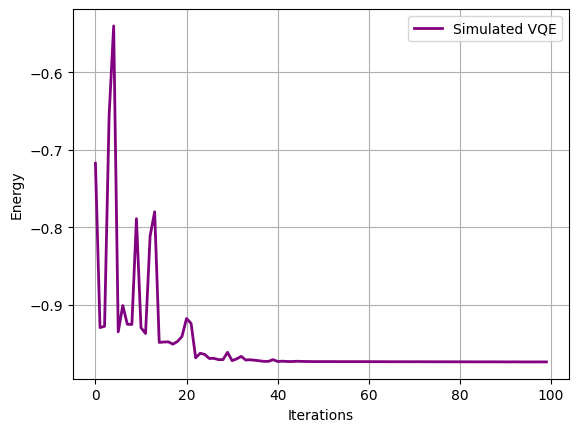

In [45]:
import matplotlib.pyplot as plt
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=ana_gs, color="tab:red", ls="--", lw=2, label="Target: " + str(ana_gs))
plt.legend()
plt.grid()
plt.show()

In [46]:
cmp_gs = problem.interpret(res_sim).total_energies[0].real
print(problem.interpret(res_sim))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.593162419164
  - computed part:      -0.973646556405
  - FreezeCoreTransformer extracted energy part: -17.619515862759
~ Nuclear repulsion energy (Hartree): 3.37181881021
> Total ground state energy (Hartree): -15.221343608954
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [15.1253679  0.0  0.0]
 


In [47]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.221343608954477
-15.59503095223075
2.3961949445366146


In [28]:
ansatz_opt = transpile(SimplAns, AerSimulator(), optimization_level =3)
print('SIMPLIFIED ANSATZ GATES: ', ansatz_opt.count_ops())

SIMPLIFIED ANSATZ GATES:  OrderedDict([('rx', 6), ('rz', 6), ('x', 3)])


In [29]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [qubit_op])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -1.3120917664083032,
    'optimal_circuit': None,
    'optimal_parameters': array([ 1.67966712e+00,  1.67821915e+00,  1.20437983e-02, -6.34570763e-04,
        1.20191948e-03, -8.11615802e-03,  8.26727590e-03, -4.56344986e-03,
        1.92508556e+00,  3.94368106e-01,  6.67506794e-01,  1.32271533e+00]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 11.89


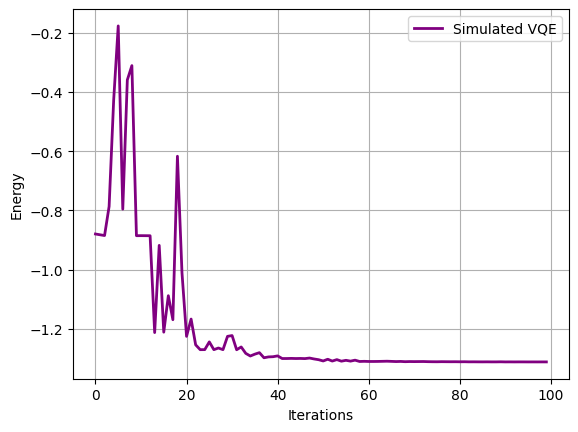

In [30]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
#plt.axhline(y=ana_gs, color="tab:red", ls="--", lw=2, label="Target: " + str(ana_gs))
plt.legend()
plt.grid()
plt.show()

In [32]:
cmp_gs = problem.interpret(res_sim).total_energies[0].real
print(problem.interpret(res_sim))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.931607629168
  - computed part:      -1.312091766408
  - FreezeCoreTransformer extracted energy part: -17.619515862759
~ Nuclear repulsion energy (Hartree): 3.37181881021
> Total ground state energy (Hartree): -15.559788818958
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [15.1253679  0.0  0.0]
 


In [33]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.559788818957902
-15.59503095223075
0.2259830928248838


In [35]:
ansatz_opt = transpile(HFAns, AerSimulator(), optimization_level =3)
print('SIMPLIFIED ANSATZ GATES: ', ansatz_opt.count_ops())

SIMPLIFIED ANSATZ GATES:  OrderedDict([('x', 3)])


In [36]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [qubit_op])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1,
    'eigenstate': None,
    'eigenvalue': -1.3121413846412089,
    'optimal_circuit': None,
    'optimal_parameters': array([], dtype=float64),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 0.10


In [38]:
cmp_gs = problem.interpret(res_sim).total_energies[0].real
print(problem.interpret(res_sim))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.931657247401
  - computed part:      -1.312141384641
  - FreezeCoreTransformer extracted energy part: -17.619515862759
~ Nuclear repulsion energy (Hartree): 3.37181881021
> Total ground state energy (Hartree): -15.559838437191
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [15.1253679  0.0  0.0]
 


In [39]:
print(cmp_gs)
print(ana_gs)
print((ana_gs-cmp_gs)/ana_gs*100)

-15.559838437190805
-15.59503095223075
0.22566492588404402
